# Spike Sorter Comparison

This notebook shows how [SpikeInterface](https://github.com/SpikeInterface) is used to spike sort and compare the same recording with multiple sorters.

Note the notebook assumes the recording is alreay sorted, the neccessary data can be downloaded here:

[https://drive.google.com/drive/folders/1ZwLDz0mmTyUYTbAJ2TX53XRa0l0zA-K-?usp=drive_open](https://drive.google.com/drive/folders/1ZwLDz0mmTyUYTbAJ2TX53XRa0l0zA-K-?usp=drive_open)

The results were generated with spikeinterface version 0.9.1.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import spikeextractors as se
import spiketoolkit as st
import pandas as pd
import spikewidgets as sw
import spikesorters as ss
import spikecomparison as sc
import numpy as np
import scipy
import seaborn as sns
from pathlib import Path
import networkx as nx

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
    
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [2]:
# set the data path
p = Path('/data/MEA/spikeinterface/Marques-Smith/')
study_folder = p

sorter_list = ['herdingspikes', 'kilosort2', 'ironclust',
               'spykingcircus', 'tridesclous', 'mountainsort4']

sortings_names = ['HerdingSpikes', 'Kilosort2', 'Ironclust',
               'SpykingCircus', 'Tridesclous', 'Mountainsort4']

sortings_names_short = ['HS', 'KS', 'IC',
               'SC', 'TDC', 'MS']

# load all sortings:
sortings = []
for s in sorter_list:
    sx = se.NpzSortingExtractor(study_folder / 'sorters' /str(s+'.npz'))
    sortings.append(sx)

print('Units found:')
for sx,s in zip(sortings, sorter_list):
    print(s+': ',len(sx.get_unit_ids()))

Units found:
herdingspikes:  243
kilosort2:  384
ironclust:  379
spykingcircus:  396
tridesclous:  42
mountainsort4:  589


In [3]:
# run a multi-comparison
mcmp_zero = sc.compare_multiple_sorters(sorting_list=sortings, name_list=sortings_names_short, verbose=False)

<Figure size 1123.2x129.6 with 0 Axes>

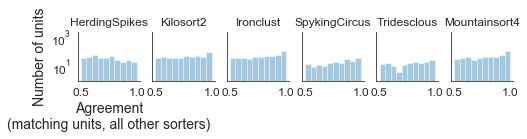

In [4]:
plt.figure(figsize=(len(sortings_names)*2.6,1.8))
g = mcmp_zero.graph
w = []
for s in sortings_names_short:
    w.append([e[2]['weight'] for e in g.edges(data=True) if ((s in e[0])|(s in e[1]))])

ax = []
fig, ax = plt.subplots(ncols=len(sortings_names), sharex=True,sharey=True,figsize=(len(sortings_names)*2.6/2,1.8/2))
for i,s in enumerate(sortings_names):
    if i>0:
        plt.setp(ax[i].get_yticklabels(), visible=False)
    p = sns.distplot(w[i], bins=10, kde=False, ax=ax[i])
    p.set_yscale('log')
    ax[i].set_title(s)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
    if i == 0:
        ax[i].set_xlabel('Agreement\n(matching units, all other sorters)')
        ax[i].set_ylabel('Number of units')        
    
for i,s in enumerate(sortings_names):
    ax[i].set_ylim(1,2000)
    ax[i].set_yticks((10,1000))


HS 0 121
IC 1 189
KS 2 192
MS 3 294
SC 4 198
TDC 5 21


/data/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/data/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/data/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


(-1.4, 1.4)

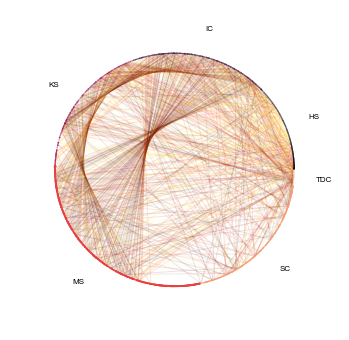

In [5]:
plt.figure(figsize=(6,6))
    
# node label sorter:
key = lambda x: str(x[:x.find('_')+1]+'{0:06d}'.format(int(x[x.find('_')+1:])))

ax = plt.subplot(111, frameon=False)
node_cmap='Accent'
edge_cmap='hot_r'

mcmp_graph = mcmp_zero.graph.copy()
g = mcmp_graph
edge_col = []
for e in g.edges(data=True):
    n1, n2, d = e
    edge_col.append(d['weight'])
nodes_col = np.array([])
nodes_size = np.array([])
nu = []
for i, sort in enumerate([sortings[ii] for ii in np.argsort(sortings_names)]):
    nu.append(len(sort.get_unit_ids()))
    nodes_col = np.concatenate((nodes_col, np.array([i] * len(sort.get_unit_ids()))))
    for j,u in enumerate(sort.get_unit_ids()):
        nodes_size = np.concatenate((nodes_size, [len(sort.get_unit_spike_train(u))]))
nodes_col = nodes_col / (len(sortings)-1)
nodes_size = 0.0001*nodes_size
labels = {}
for i,s in enumerate([sortings_names_short[ii] for ii in np.argsort(sortings_names)]):
    print(s,i, nu[i]//2)
    labels[s+'_'+str(int(nu[i]//2))] = s
pos = nx.circular_layout(sorted(g, key=key), scale=1)
_ = nx.draw_networkx_edges(g, pos=pos, ax=ax, edge_color=edge_col, 
                           edge_cmap=plt.cm.get_cmap(edge_cmap), edge_vmin=0.5, edge_vmax=1, width=1,
                          nodelist=sorted(g.nodes, key=key), alpha=0.1)
_ = nx.draw_networkx_nodes(g, pos=pos, ax=ax, node_color=nodes_col, 
                           node_size=nodes_size, nodelist=sorted(g.nodes, key=key))
for p in pos:
    pos[p][0] *= 1.25
    pos[p][1] *= 1.25
_ = nx.draw_networkx_labels(g, pos=pos, labels=labels, ax=ax, nodelist=sorted(g.nodes, key=key), font_size=8)

ax.set_xlim((-1.4,1.4))
ax.set_ylim((-1.4,1.4))


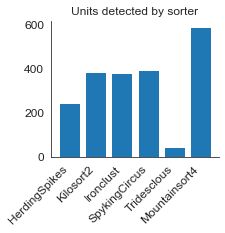

In [6]:
# number of units found
plt.figure(figsize=(3,2.5))
    
ax = plt.subplot(111)
n = []
for s in sortings:
    n.append(len(s.get_unit_ids()))
plt.bar(range(len(sortings)), n)
ax.set_xticks(range(len(sortings_names)))
ax.set_xticklabels(sortings_names, rotation=45, ha='right')
plt.title('Units detected by sorter') 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Found split unit (ignore in analysis): 58 
 ['KS_370', 'IC_271', 'MS_344', 'MS_351', 'HS_58', 'KS_368'] 
 [('KS_370', 'HS_58'), ('KS_370', 'MS_344'), ('IC_271', 'HS_58'), ('IC_271', 'KS_368'), ('IC_271', 'MS_351'), ('MS_351', 'HS_58'), ('MS_351', 'KS_368')] 
 [1, 2, 5, 5, 0, 1]
Found split unit (ignore in analysis): 121 
 ['HS_121', 'TDC_0', 'IC_262', 'HS_122', 'SC_245', 'KS_239', 'MS_336'] 
 [('HS_121', 'IC_262'), ('TDC_0', 'HS_122'), ('TDC_0', 'KS_239'), ('TDC_0', 'IC_262'), ('TDC_0', 'SC_245'), ('TDC_0', 'MS_336'), ('IC_262', 'KS_239'), ('IC_262', 'SC_245'), ('IC_262', 'MS_336'), ('HS_122', 'KS_239'), ('HS_122', 'SC_245'), ('HS_122', 'MS_336'), ('SC_245', 'KS_239'), ('SC_245', 'MS_336'), ('KS_239', 'MS_336')] 
 [0, 4, 2, 0, 3, 1, 5]
Found split unit (ignore in analysis): 145 
 ['HS_146', 'KS_64', 'IC_66', 'MS_85', 'KS_62'] 
 [('HS_146', 'KS_62'), ('HS_146', 'IC_66'), ('HS_146', 'MS_85'), ('KS_64', 'IC_66'), ('KS_64', 'MS_85'), ('IC_66', 'MS_85')] 
 [0, 1, 2, 5, 1]
Found split unit (

/data/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/networkx/algorithms/components/connected.py:86: DeprecationWarning: connected_component_subgraphs is deprecated and will be removedin 2.2. Use (G.subgraph(c).copy() for c in connected_components(G))
  _warnings.warn(msg, DeprecationWarning)


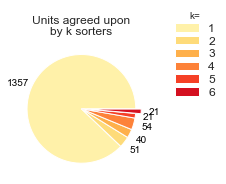

In [7]:
# number of matched units found
plt.figure(figsize=(3,2.5))
    
# find subgraphs and get sorter IDs for each
subgraphs = nx.connected_component_subgraphs(g)
sg_sorters = []
for i, sg in enumerate(subgraphs):
    # incomprehensible list comprehension, just trust it
    s = [j for n in sg.nodes for j, s in enumerate(sortings_names_short) if s in n]
    sg_sorters.append(np.unique(s))
    if True in (t>1 for t in np.unique(s, return_counts=True)[1]):
        print('Found split unit (ignore in analysis):',i,'\n',sg.nodes,'\n',sg.edges,'\n',s)

def getabs(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    if absolute>3:
        return "{:d}".format(absolute)
    else:
        return None

cmap = plt.get_cmap('YlOrRd')
colors = np.array([cmap(i) for i in np.linspace(0.1, 0.8, len(sortings_names))])
    
# fraction of units with agreement >threshold  
ax = plt.subplot(111)
v,c = np.unique([len(s) for s in sg_sorters], return_counts=True)
p = ax.pie(c, labels=v, colors=colors[v-1], autopct=lambda pct: getabs(pct, c), textprops={'color':'k', 'fontsize':10}, 
        pctdistance=1.25, labeldistance=None, explode=np.append(np.zeros(len(sortings_names)-1),0.1));
plt.title('Units agreed upon\nby k sorters'.format(len(sortings_names)));
plt.legend(p[0], v, frameon=False, title='k=',
           bbox_to_anchor=(1.15, 1.25), loc=2, borderaxespad=0., labelspacing=0.2)


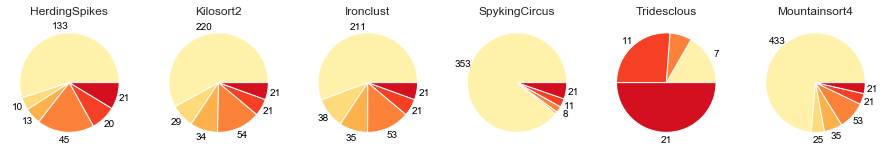

In [8]:
# matching units per sorter

plt.figure(figsize=(len(sortings_names)*2.6,2.4))

for i,s in enumerate(sortings_names):
    plt.subplot(1,len(sortings_names),i+1)
    v,c = np.unique([len(s) for s in sg_sorters if i in s], return_counts=True)
    plt.pie(c, labels=v, colors=colors[v-1], autopct=lambda pct: getabs(pct, c), textprops={'color':'k', 'fontsize':10}, 
            pctdistance=1.15, labeldistance=None);
    plt.title(s)
    
